In [190]:
import pandas as pd 

import psana as ps
import numpy as np
import math 
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.polynomial import Polynomial as npply
import sys
import os
import h5py
import scipy.stats as st
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter as gf
from sklearn.utils import resample
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/TestCode/EarlyScience/AnalyzeH5/')
from chemRIXSAnalysis import *
from ChemRIXSClasses import *
from filterTools import *
sys.path.append('/reg/data/ana16/rix/rixlv1519/results/LCLS_LV15_2021/Functions/')
from Functions import *
from Load_Scans import *
from raw_data_class import RawData as RDC
from pro_data_class import ProData as PDC


font = {'size'   : 16}
mpl.rc('font', **font)
%matplotlib widget
cmap = plt.cm.get_cmap('terrain').reversed()

Next steps:

Calibrate from mono_encoder to mono_eV

Figure out how to deal with the weird jump at the beginning of mono scans. (look at distribution and then select range before binning maybe?)

Bin shots every 0.2 eV.

Separate into laser on vs laser off. 

Bin laser on into time bins.

Filter things here?




In [191]:
exp = 'rixlv1519'
small_data_folder = '/reg/data/ana01/rix/%s/hdf5/smalldata/' % exp #changeme
scans = [88]
raw = h5py.File(small_data_folder+'%s_Run%04d.h5' % (exp,scans[0]))

In [192]:
raw_datas = []
for scan in scans:
    raw_data = load_scans(small_data_folder,exp,scan)
    
    I0_intensities_fim0, I0_specs_fim0, baselines_fim0 = \
    process_fim(raw_data.fim0_raw,np.arange(0,8),np.arange(0,50),np.arange(103,112))
    
    I0_intensities_fim1, I0_specs_fim1, baselines_fim1 = \
    process_fim(raw_data.fim1_raw,np.arange(0,8),np.arange(0,50),np.arange(103,112))
             
    intensities_fim2=process_fim_2(raw_data.fim2_raw,np.arange(0,8))
    
    andor_dir_intensities, andor_dir_specs, baseline_andor_dir = \
    process_andor(raw_data.andor_dir_raw,np.arange(500,800),np.arange(900,1250))
    
#     if raw_data.laser == 1:
#         r = []
        
#     if raw_data.laser == 0:
#         r = []

    raw_data.changeValue(I0_intensities_fim0=I0_intensities_fim0,
                        I0_specs_fim0=I0_specs_fim0,
                        baselines_fim0=baselines_fim0,
                        I0_intensities_fim1=I0_intensities_fim1,
                        I0_specs_fim1=I0_specs_fim1,
                        baselines_fim1=baselines_fim1,
                        intensities_fim2=intensities_fim2,
                        andor_dir_intensities=andor_dir_intensities,
                        andor_dir_specs=andor_dir_specs,
                        baseline_andor_dir=baseline_andor_dir
                        )
    
    
    raw_datas = raw_datas + [raw_data]
print(raw_datas[0].getKeys())

generating mono_encoder_ev
loading TT
loading fim0
loading fim1
loading andor
loading fim2
dict_keys(['events', 'xgmd', 'gmd', 'energy_raw', 'mono_encoder', 'pitch_raw', 'horz_raw', 'evrs', 'lxt', 'laser', 'nan_cond', 'mono_encoder_ev', 'tt_pos', 'tt_posps', 'tt_posfwhm', 'fim0_raw', 'fim1_raw', 'andor_dir_raw', 'fim2_raw', 'I0_intensities_fim0', 'I0_specs_fim0', 'baselines_fim0', 'I0_intensities_fim1', 'I0_specs_fim1', 'baselines_fim1', 'intensities_fim2', 'andor_dir_intensities', 'andor_dir_specs', 'baseline_andor_dir'])


In [161]:
print(raw_datas[0].pitch_raw[0:10])
print(raw_data.pitch_raw)

'''
events = ?? some huge numberr, variable 432347543xxxxxxxxxx
xgmd = ?? variable number, 10-4
gmd = ?? variable number, 10-3
energy_raw = ?? energy in eV, but constant? not the start point.... wtf?
mono_encoder = monochromater encoder value, increasing.
pitch_raw
horz_raw
'''


[]
[153619.28944  153619.28944  153619.28944  ... 153619.436655 153619.436655
 153619.436655]


'\nevents = ?? some huge numberr, variable 432347543xxxxxxxxxx\nxgmd = ?? variable number, 10-4\ngmd = ?? variable number, 10-3\nenergy_raw = ?? energy in eV, but constant? not the start point.... wtf?\nmono_encoder = monochromater encoder value, increasing.\npitch_raw\nhorz_raw\n'

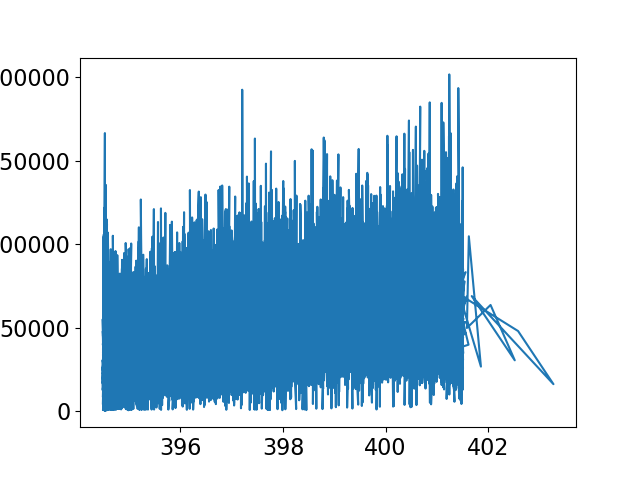

In [194]:
plt.figure()
plt.plot(raw_datas[0].mono_encoder_ev,raw_datas[0].andor_dir_intensities)

In [ ]:
     if raw_data.laser[x] == 1:
         r = []
        else 

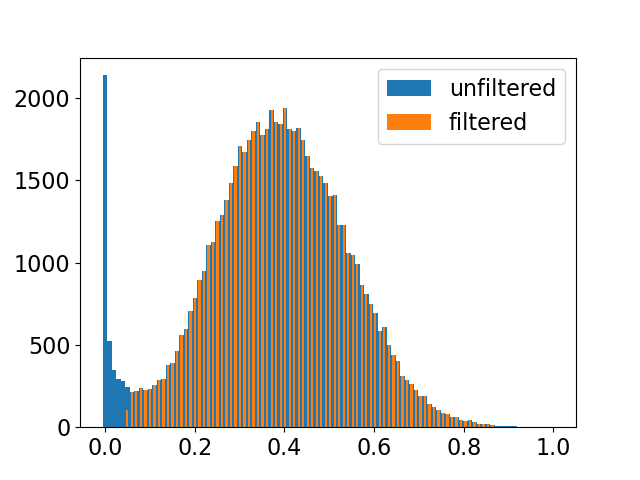

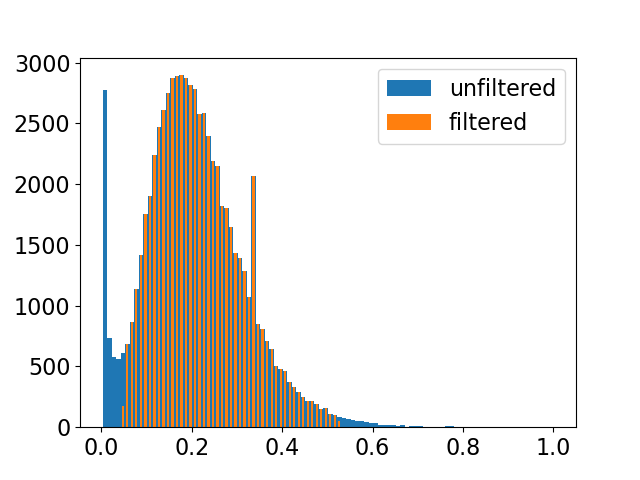

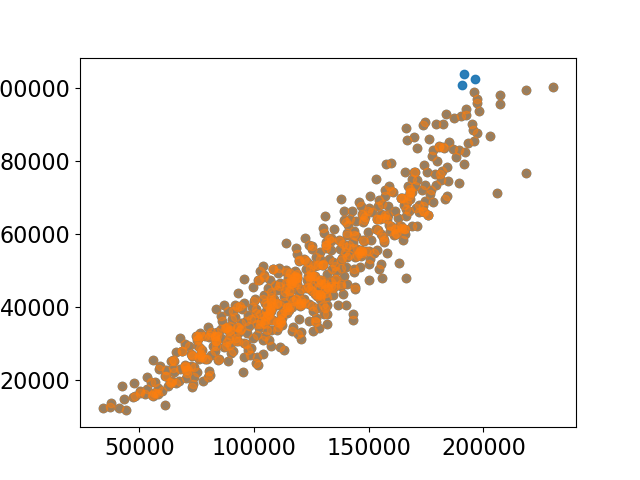

ValueError: zero-size array to reduction operation maximum which has no identity

In [208]:
plt.close('all')
scans_to_plot = [0]
n_bins = 75
start_bin = 396
# plt.figure()
to_average = [88]
fim0_channels = [4,5,6,7]#,5,6,7]#,5,6,7]#,5,6,7]#,5,6,7]
fim1_channels = [5,6]
#on_or_off 0
for scan in scans_to_plot:
    #pump_cond=raw_datas[scan].laser=on_or_off
    all_events = raw_datas[scan].events    
    x_axis = raw_datas[scan].mono_encoder_ev
    andor = raw_datas[scan].andor_dir_intensities
    
    
    fim_0 = np.sum(raw_datas[scan].I0_intensities_fim0[fim0_channels,:],0)
    fim_1 = np.sum(raw_datas[scan].I0_intensities_fim1[fim1_channels,:],0)
    
    all_Izero = fim_0
#     all_Izero = fim_1
#    all_Izero = np.sum(np.array((fim_0,fim_1)),0)
    
#     fim_0 = raw_datas[scan].I0_intensities_fim1[7,:]


    B_condition_1 = bounds_filter(all_Izero/np.max(all_Izero)\
                                        ,[[0.05,'None'],[3]],True) 
    B_condition_2 = bounds_filter(andor/np.max(andor)\
                                        ,[[0.05,'None'],[3]],True) 
    bounds_conditions = B_condition_1 & B_condition_2
    

    x_value = x_axis[np.logical_and(bounds_conditions,x_axis>start_bin)]
    y_value = all_Izero[np.logical_and(bounds_conditions,x_axis>start_bin)]
    bins, Izero_binned_means, Izero_binned_shots = energy_binning(x_value,y_value,n_bins)

    y_value = andor[np.logical_and(bounds_conditions,x_axis>start_bin)]
    bins, andor_binned_means, andor_binned_shots = energy_binning(x_value,y_value,n_bins)

    y_value = all_events[np.logical_and(bounds_conditions,x_axis>start_bin)]
    bins, trash, events_binned = energy_binning(x_value,y_value,n_bins)
    
    lin_conditions = []
    plot = False
    for i in range(0,n_bins-1):
            if i is 10:
                plot = True
                
            lin_conditions.append(lin_filter(Izero_binned_shots[i],andor_binned_shots[i]\
                                        ,[0.1,True],plot))
            
            plot = False
    lin_conditions = np.asarray(lin_conditions,dtype=object)

    andor_filt_and_binned = np.asarray([andor_shots[lin_cond] \
                                        for andor_shots,lin_cond in zip(andor_binned_shots,lin_conditions)],dtype=object)
    Izero_filt_and_binned = np.asarray([Izero_shots[lin_cond] \
                                        for Izero_shots,lin_cond in zip(Izero_binned_shots,lin_conditions)],dtype=object)

    
    events_filt_and_binned = np.asarray([events_binned[lin_cond] \
                                        for events_binned,lin_cond in zip(events_binned,lin_conditions)],dtype=object)
    andor_filt_and_binned_means = np.asarray([np.mean(x) for x in andor_filt_and_binned])
    izero_filt_and_binned_means = np.asarray([np.mean(x) for x in Izero_filt_and_binned])

    norm_then_mean = np.asarray([np.mean(x) for x in andor_filt_and_binned/Izero_filt_and_binned])
    mean_then_norm = np.asarray([np.mean(x)/np.mean(y) for x,y in zip(andor_filt_and_binned,Izero_filt_and_binned)])
    to_average.append(norm_then_mean)

In [201]:
#NOT THIS NODE

plt.close('all')
scans_to_plot = [0]
n_bins = 75
start_bin = 396
# plt.figure()
to_average = [78,79]
fim0_channels = [4,5,6,7]#,5,6,7]#,5,6,7]#,5,6,7]#,5,6,7]
fim1_channels = [5,6]
#on_or_off 0
#elsecount=0
for scan in scans_to_plot:
    #pump_cond=raw_datas[scan].laser=on_or_off
    elsecount+=1
    if raw_datas[scan].laser == 1:
        #elsecount+=1
        all_events = raw_datas[scan].events    
        x_axis = raw_datas[scan].mono_encoder_ev
        andor = raw_datas[scan].andor_dir_intensities


        fim_0 = np.sum(raw_datas[scan].I0_intensities_fim0[fim0_channels,:],0)
        fim_1 = np.sum(raw_datas[scan].I0_intensities_fim1[fim1_channels,:],0)

        all_Izero = fim_0
    #     all_Izero = fim_1
    #    all_Izero = np.sum(np.array((fim_0,fim_1)),0)

    #     fim_0 = raw_datas[scan].I0_intensities_fim1[7,:]


        B_condition_1 = bounds_filter(all_Izero/np.max(all_Izero)\
                                            ,[[0.05,'None'],[3]],True) 
        B_condition_2 = bounds_filter(andor/np.max(andor)\
                                            ,[[0.05,'None'],[3]],True) 
        bounds_conditions = B_condition_1 & B_condition_2


        x_value = x_axis[np.logical_and(bounds_conditions,x_axis>start_bin)]
        y_value = all_Izero[np.logical_and(bounds_conditions,x_axis>start_bin)]
        bins, Izero_binned_means, Izero_binned_shots = energy_binning(x_value,y_value,n_bins)

        y_value = andor[np.logical_and(bounds_conditions,x_axis>start_bin)]
        bins, andor_binned_means, andor_binned_shots = energy_binning(x_value,y_value,n_bins)

        y_value = all_events[np.logical_and(bounds_conditions,x_axis>start_bin)]
        bins, trash, events_binned = energy_binning(x_value,y_value,n_bins)

        lin_conditions = []
        plot = False
        for i in range(0,n_bins-1):
                if i is 10:
                    plot = True

                lin_conditions.append(lin_filter(Izero_binned_shots[i],andor_binned_shots[i]\
                                            ,[0.1,True],plot))

                plot = False
        lin_conditions = np.asarray(lin_conditions,dtype=object)

        andor_filt_and_binned = np.asarray([andor_shots[lin_cond] \
                                            for andor_shots,lin_cond in zip(andor_binned_shots,lin_conditions)],dtype=object)
        Izero_filt_and_binned = np.asarray([Izero_shots[lin_cond] \
                                            for Izero_shots,lin_cond in zip(Izero_binned_shots,lin_conditions)],dtype=object)


        events_filt_and_binned = np.asarray([events_binned[lin_cond] \
                                            for events_binned,lin_cond in zip(events_binned,lin_conditions)],dtype=object)
        andor_filt_and_binned_means = np.asarray([np.mean(x) for x in andor_filt_and_binned])
        izero_filt_and_binned_means = np.asarray([np.mean(x) for x in Izero_filt_and_binned])

        norm_then_meanI = np.asarray([np.mean(x) for x in andor_filt_and_binned/Izero_filt_and_binned])
        mean_then_norm = np.asarray([np.mean(x)/np.mean(y) for x,y in zip(andor_filt_and_binned,Izero_filt_and_binned)])
        to_average.append(norm_then_meanI)
    else:
        elsecount+=1
        all_events = raw_datas[scan].events    
        x_axis = raw_datas[scan].mono_encoder_ev
        andor = raw_datas[scan].andor_dir_intensities


        fim_0 = np.sum(raw_datas[scan].I0_intensities_fim0[fim0_channels,:],0)
        fim_1 = np.sum(raw_datas[scan].I0_intensities_fim1[fim1_channels,:],0)

        all_Izero = fim_0
    #     all_Izero = fim_1
    #    all_Izero = np.sum(np.array((fim_0,fim_1)),0)

    #     fim_0 = raw_datas[scan].I0_intensities_fim1[7,:]


        B_condition_1 = bounds_filter(all_Izero/np.max(all_Izero)\
                                            ,[[0.05,'None'],[3]],True) 
        B_condition_2 = bounds_filter(andor/np.max(andor)\
                                            ,[[0.05,'None'],[3]],True) 
        bounds_conditions = B_condition_1 & B_condition_2


        x_value = x_axis[np.logical_and(bounds_conditions,x_axis>start_bin)]
        y_value = all_Izero[np.logical_and(bounds_conditions,x_axis>start_bin)]
        bins, Izero_binned_means, Izero_binned_shots = energy_binning(x_value,y_value,n_bins)

        y_value = andor[np.logical_and(bounds_conditions,x_axis>start_bin)]
        bins, andor_binned_means, andor_binned_shots = energy_binning(x_value,y_value,n_bins)

        y_value = all_events[np.logical_and(bounds_conditions,x_axis>start_bin)]
        bins, trash, events_binned = energy_binning(x_value,y_value,n_bins)

        lin_conditions = []
        plot = False
        for i in range(0,n_bins-1):
                if i is 10:
                    plot = True

                lin_conditions.append(lin_filter(Izero_binned_shots[i],andor_binned_shots[i]\
                                            ,[0.1,True],plot))

                plot = False
        lin_conditions = np.asarray(lin_conditions,dtype=object)

        andor_filt_and_binned = np.asarray([andor_shots[lin_cond] \
                                            for andor_shots,lin_cond in zip(andor_binned_shots,lin_conditions)],dtype=object)
        Izero_filt_and_binned = np.asarray([Izero_shots[lin_cond] \
                                            for Izero_shots,lin_cond in zip(Izero_binned_shots,lin_conditions)],dtype=object)


        events_filt_and_binned = np.asarray([events_binned[lin_cond] \
                                            for events_binned,lin_cond in zip(events_binned,lin_conditions)],dtype=object)
        andor_filt_and_binned_means = np.asarray([np.mean(x) for x in andor_filt_and_binned])
        izero_filt_and_binned_means = np.asarray([np.mean(x) for x in Izero_filt_and_binned])

        norm_then_mean_laseroff = np.asarray([np.mean(x) for x in andor_filt_and_binned/Izero_filt_and_binned])
        mean_then_norm_laseroff = np.asarray([np.mean(x)/np.mean(y) for x,y in zip(andor_filt_and_binned,Izero_filt_and_binned)])
        to_average.append(norm_then_mean_laseroff)
print(elsecount)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

NameError: name 'norm_then_meanI' is not defined

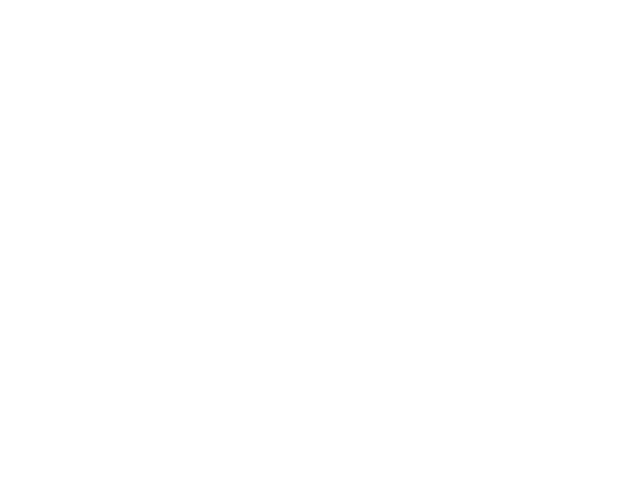

In [203]:
plt.figure()
# plt.plot(bins[0:-1],izero_filt_and_binned_means)
# plt.plot(bins[0:-1],andor_filt_and_binned_means/np.max(andor_filt_and_binned_means))
# plt.plot(bins[0:-1],izero_filt_and_binned_means/np.max(izero_filt_and_binned_means))
# plt.plot(bins[0:-1],andor_filt_and_binned_means/np.max(andor_filt_and_binned_means))
plt.plot(bins[0:-1],norm_then_meanI)
#plt.plot(bins[50:-1],norm_then_mean_laseroff[50:])
#plt.plot(bins[0:-1],mean_then_norm_laseroff)


plt.show()

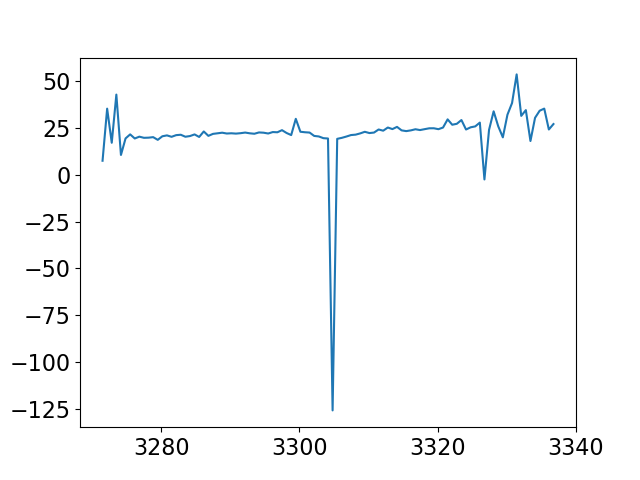

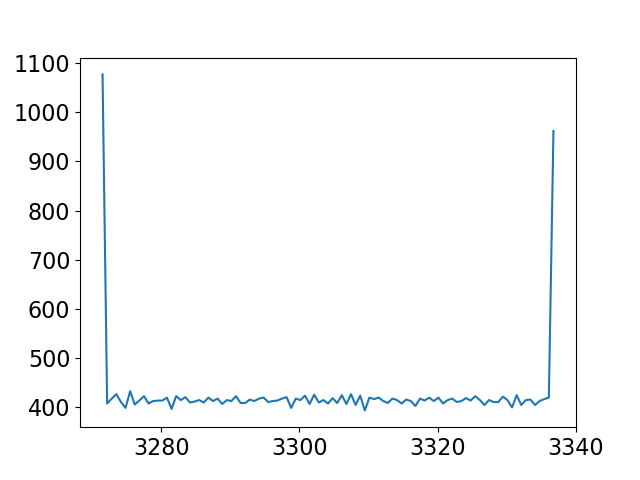

In [63]:
plt.close('all')
# scan = 4
for scan in [0]:
    data = raw_datas[scan]
#     cond = bounds_params[scan].condition
    norm_by = raw_datas[scan].I0_intensities_fim1[7,:]
    all_fims = np.sum(raw_datas[scan].I0_intensities_fim1[[4,6,7],:],0)

    y_value = data.andor_dir_intensities/norm_by
#     y_value = norm_by**2

    # y_value = np.mean(data.I0_intensities_fim0[4:7,:],0)
    x_value = data.mono_encoder
    n_bins = 100
    bins,intensity,shots = energy_binning(x_value,y_value,n_bins)
    shots_per_bin = np.asarray([i.shape[0] for i in shots])

    plt.figure(15)
    plt.plot(bins[0:-1],intensity)#/np.max(intensity))
    plt.show()
    plt.figure(16)
    # _, bins, _ = plt.hist(shots)#, 100, label='unfiltered')
    plt.plot(bins[0:-1],shots_per_bin)
    plt.show()